### Hate Speech on Twitter Assignment

This is an assignment from a machine learning class where we had to analyze and recognize hate speech.

#### Disclaimer:
These tweets can be harmful. Avoid reading tweets or outputs from code if you could be offended by this.

In [1]:
import re
import json
import random
import collections

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model, svm
from sklearn.feature_extraction.text import TfidfTransformer

%matplotlib inline  

# Standard plot size
plt.rcParams['figure.figsize'] = (15, 10) 

---

For this assignment we pre-processed these tweets by:

- removing unwanted characters, explicit mentions, urls and hashtags (they have been replaced by dummy tags, see below)

- automatically tokenizing the text and annotating the grammatical category and lemma of each token

These data are available in the `labeled_data_preprocessed.csv` file available in the `data` folder, whose structure looks as follows: 

In [2]:
df = pd.read_csv("data/labeled_data_preprocessed.csv", index_col = 0)
annotation_re = re.compile(r"(.+)/(.+)")
df['pos_tagged_tweet'] = df['pos_tagged_tweet'].apply(lambda x: [annotation_re.findall(s)[0] for s in x.split()])
df['lemmatized_tweet'] = df['lemmatized_tweet'].apply(lambda x: [annotation_re.findall(s)[0] for s in x.split()])
df.head(15)  # the first 25 tweets, along with their annotation

,count,hate_speech,offensive_language,neither,class,raw_tweet,pos_tagged_tweet,lemmatized_tweet
id,,,,,,,,
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,"[(!, .), (!, .), (!, .), (rt, NOUN), (mentionh...","[(!, !), (!, !), (!, !), (rt, rt), (mentionher..."
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,"[(!, .), (!, .), (!, .), (rt, NOUN), (mentionh...","[(!, !), (!, !), (!, !), (rt, rt), (mentionher..."
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,"[(!, .), (!, .), (!, .), (rt, NOUN), (mentionh...","[(!, !), (!, !), (!, !), (rt, rt), (mentionher..."
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,"[(!, .), (!, .), (!, .), (rt, NOUN), (mentionh...","[(!, !), (!, !), (!, !), (rt, rt), (mentionher..."
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,"[(!, .), (!, .), (!, .), (rt, NOUN), (mentionh...","[(!, !), (!, !), (!, !), (rt, rt), (mentionher..."
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...","[(!, .), (!, .), (!, .), (mentionhere, NOUN), ...","[(!, !), (!, !), (!, !), (mentionhere, mention..."
6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ...","[(!, .), (!, .), (!, .), (mentionhere, NOUN), ...","[(!, !), (!, !), (!, !), (mentionhere, mention..."
7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,"[(!, .), (!, .), (!, .), (mentionhere, ADV), (...","[(!, !), (!, !), (!, !), (mentionhere, mention..."
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ...","[(&, CONJ), (you, PRON), (might, VERB), (not, ...","[(&, &), (you, you), (might, might), (not, not..."


### Legend: Columns keys

**`count`** = number of human annotators who coded each tweet (min is 3).

**`hate_speech`** = number of annotators who judged the tweet to be hate speech.

**`offensive_language`** = number of annotators who judged the tweet to be offensive.

**`neither`** = number of annotators who judged the tweet to be neither offensive nor non-offensive.

**`class`** = class label for majority of annotators (**this is our target label**).

    0 - hate speech
    1 - offensive language
    2 - neither
   
**`raw_tweet`** = raw tweet text (very noisy, it should be used only for inspection and/or to run a processing pipeline from scratch)

**`pos_tagged_tweet`** = an annotated version of each tweet obtained by:

    - cleaning the tweet (removing unwanted characters and lowering the text)
    - replacing mentions, hashtags and url with the "MENTIONHERE", "HASHTAGHERE" and "URLHERE" tag, respectively
    - tokenizing the text (roughly, splitting the into morphological units such as words and punctuation marks)
    - annotating the grammatical category (a.k.a. Part of Speech: PoS) of each token

**`lemmatized_tweet`** = annotated version of each tweet obtained by using the annotation available in the `pos_tagged_tweet` representation in order to tag the base form (e.g. "*be*" for the inflected word "*am*") of each token.

#### Tagging notation

The pos-tagged and the lemmatized tweets have been represented using the [nltk notation](http://www.nltk.org/book_1ed/ch05.html), where 

- each **tweet** is represented as a list of annotated tokens

- each **annotated token** is represented as a `(attested word, tag)` tuple

For instance, we can verbalize the following PoS annotation as:

> *"the article "the" is followed by the adjective "grand", in turn followed by the noun "jury" and the verb "commented"*

`[('The', 'DET'), ('grand', 'ADJ'), ('jury', 'NOUN'), ('commented', 'VERB')]`

... while the following lemmatized text can be read as 

> *the text is composed by inflected forms of the lemmas "the", "grand", "jury" and "comment"* (note that the only token that is different from its base form is the latter)

`[('The', 'The'), ('grand', 'grand'), ('jury', 'jury'), ('commented', 'comment')]`


#### Part of Speech TagSet

For PoS-tagging our tweets we've used the Universal tagset proposed by [Petrov et al (2011)](https://arxiv.org/abs/1104.2086):

|  tag  | meaning |
|:-----:|:---------|
| VERB | verbs (all tenses and modes) |
| NOUN | nouns (common and proper) |
| PRON | pronouns |
| ADJ | adjectives |
| ADV | adverbs |
| ADP | adpositions (prepositions and postpositions) |
| CONJ | conjunctions |
| DET | determiners |
| NUM | cardinal numbers |
| PRT | particles or other function words |
| X | other: foreign words, typos, abbreviations |
| \. | punctuation |

In [3]:
df_dict = df.to_dict()

In [4]:
# note that the keys of the outmost dictionary are the column names
print(df_dict.keys())

dict_keys(['count', 'hate_speech', 'offensive_language', 'neither', 'class', 'raw_tweet', 'pos_tagged_tweet', 'lemmatized_tweet'])


In [5]:
# while the keys of each embedded dictionary are the rows indices
print(list(df_dict['raw_tweet'].keys())[:100])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


---

## Feature extraction

In this step, we'll extract the features that we will later used to convert each tweet into a vector. Let's store all the estimates as subdictionaries of a `features_dictionary` dictionary of dictionaries:

In [6]:
features_dictionary = dict()

- **Number of tokens in each tweet**

In [7]:
rawList = df_dict['raw_tweet']
token_counts = dict()

for x in rawList.keys():
    tweet = rawList[x]
    tokens = nltk.word_tokenize(tweet)
    token_counts[x] = len(tokens)
    
features_dictionary["tokens_counts"] = token_counts

print(list(features_dictionary["tokens_counts"].values())[:10])

[34, 26, 35, 20, 43, 53, 31, 30, 17, 11]


- **Number of characters in each tweet**

In [8]:
tweetList = df_dict['lemmatized_tweet']
character_counts = dict()

for x in tweetList.keys():
    charCount = 0
    for orig,lem in tweetList[x]:
        charCount += len(orig)
    character_counts[x] = charCount
    
features_dictionary["characters_counts"] = character_counts

print(list(df_dict['lemmatized_tweet'].values())[:1])
print(list(features_dictionary["characters_counts"].values())[:10])

[[('!', '!'), ('!', '!'), ('!', '!'), ('rt', 'rt'), ('mentionhere', 'mentionhere'), (':', ':'), ('as', 'a'), ('a', 'a'), ('woman', 'woman'), ('you', 'you'), ("shouldn't", "shouldn't"), ('complain', 'complain'), ('about', 'about'), ('cleaning', 'clean'), ('up', 'up'), ('your', 'your'), ('house', 'house'), ('.', '.'), ('&', '&'), ('as', 'a'), ('a', 'a'), ('man', 'man'), ('you', 'you'), ('should', 'should'), ('always', 'always'), ('take', 'take'), ('the', 'the'), ('trash', 'trash'), ('out', 'out'), ('...', '...')]]
[110, 71, 90, 46, 90, 95, 77, 67, 36, 46]


- **Count indicators for hashtags, mentions, and URLs**

In [9]:
num_hashtags = dict()
num_mentions = dict()
num_urls = dict()

for x in tweetList.keys():
    hashCount = 0
    mentCount = 0
    urlsCount = 0
    for orig,lem in tweetList[x]:
        if orig == 'hashtaghere':
            hashCount += 1
        elif orig == 'mentionhere':
            mentCount += 1
        elif orig == 'urlhere':
            urlsCount += 1
    num_hashtags[x] = hashCount
    num_mentions[x] = mentCount
    num_urls[x] = urlsCount
    
features_dictionary["num_hashtags"] = num_hashtags
features_dictionary["num_mentions"] = num_mentions
features_dictionary["num_urls"] = num_urls

print(list(df_dict['pos_tagged_tweet'].values())[10:20])
print(list(features_dictionary["num_hashtags"].values())[:20])
print(list(features_dictionary["num_mentions"].values())[:20])
print(list(features_dictionary["num_urls"].values())[:20])

[[('keeks', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('bitch', 'NOUN'), ('she', 'PRON'), ('curves', 'VERB'), ('everyone', 'NOUN'), ('lol', 'NOUN'), ('i', 'NOUN'), ('walked', 'VERB'), ('into', 'ADP'), ('a', 'DET'), ('conversation', 'NOUN'), ('like', 'ADP'), ('this', 'DET'), ('.', '.'), ('smh', 'NOUN')], [('murda', 'NOUN'), ('gang', 'NOUN'), ('bitch', 'VERB'), ('its', 'PRON'), ('gang', 'NOUN'), ('land', 'NOUN')], [('so', 'ADV'), ('hoes', 'VERB'), ('that', 'ADP'), ('smoke', 'NOUN'), ('are', 'VERB'), ('losers', 'NOUN'), ('?', '.'), ('yea', 'NOUN'), ('...', '.'), ('go', 'VERB'), ('on', 'ADP'), ('ig', 'NOUN')], [('bad', 'ADJ'), ('bitches', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('only', 'ADJ'), ('thing', 'NOUN'), ('that', 'ADP'), ('i', 'NOUN'), ('like', 'ADP')], [('bitch', 'NOUN'), ('get', 'VERB'), ('up', 'PRT'), ('off', 'ADP'), ('me', 'PRON')], [('bitch', 'NOUN'), ('nigga', 'NOUN'), ('miss', 'VERB'), ('me', 'PRON'), ('with', 'ADP'), ('it', 'PRON')], [('bitch', 'NOUN'), ('plz', 'NOUN'), ('wh

- **Binary indicator for retweet**

In [10]:
is_retweet = dict()

for x in tweetList.keys():
    isRetweet = 0
    for orig,lem in tweetList[x]:
        if orig == 'rt':
            isRetweet = 1
    is_retweet[x] = isRetweet
    
features_dictionary["is_retweet"] = is_retweet

print(list(features_dictionary["is_retweet"].values())[:10])
print(list(df_dict["pos_tagged_tweet"].values())[:1])

[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[[('!', '.'), ('!', '.'), ('!', '.'), ('rt', 'NOUN'), ('mentionhere', 'ADV'), (':', '.'), ('as', 'ADP'), ('a', 'DET'), ('woman', 'NOUN'), ('you', 'PRON'), ("shouldn't", 'VERB'), ('complain', 'VERB'), ('about', 'ADP'), ('cleaning', 'VERB'), ('up', 'PRT'), ('your', 'PRON'), ('house', 'NOUN'), ('.', '.'), ('&', 'CONJ'), ('as', 'ADP'), ('a', 'DET'), ('man', 'NOUN'), ('you', 'PRON'), ('should', 'VERB'), ('always', 'ADV'), ('take', 'VERB'), ('the', 'DET'), ('trash', 'NOUN'), ('out', 'ADP'), ('...', '.')]]


- **Number of emoticons in each tweet**

In [11]:
emoticons_count = dict()

for x in rawList.keys():
    numEmoticon = 0
    tweet = rawList[x]
    words = tweet.split(" ")
    for word in words:
        if re.search(r"&#\w+;", word):
            numEmoticon += 1
    emoticons_count[x] = numEmoticon
    
features_dictionary["emoticons_count"] = emoticons_count

print(list(features_dictionary["emoticons_count"].values())[:10])
print(list(df_dict["raw_tweet"].values())[7:8])

[0, 0, 0, 0, 1, 1, 0, 2, 0, 0]
["!!!!&#8220;@selfiequeenbri: cause I'm tired of you big bitches coming for us skinny girls!!&#8221;"]


- **BOW features**

The `data/hatebase.json` file contains the original lexicon from `Hatebase.org` that was used to sample tweets. 

Counting occurences of significant words.

In [12]:
with open("data/hatebase.json", "r", encoding="utf8") as infile:
    hatebase = set(json.loads(infile.read()))
    
hatebase_frequencies = dict()

for sigword in hatebase:
    tweet_occurences = dict()
    occurences = 0
    for x in tweetList.keys():
        for orig,tword in tweetList[x]:
            if tword == sigword:
                occurences += 1
        tweet_occurences[x] = occurences
    
    hatebase_frequencies[sigword] = tweet_occurences

- **n-grams features**

The `data/refined_ngram.json` file contains a manually selected lexicon of *n-grams* (i.e. a contiguous sequence of *n* words), where $1 < n < 5$.

Counting occurences of significant n-grams.

In [13]:
with open("data/refined_ngram.json", "r", encoding="utf8") as infile:
    refined_ngrams = set(json.loads(infile.read()))
    
ngrams_frequencies = dict()

for ngram in refined_ngrams:
    ngram_occurences = dict()
    ngramlen = len(ngram.split(" "))
    for x in rawList.keys():
        occurences = 0
        words = rawList[x].split(" ")
        for gramList in list(nltk.ngrams(words,ngramlen)):
            tweetgram = ' '.join(gramList)
            if tweetgram == ngram:
                occurences += 1
                
        ngram_occurences[x] = occurences
        
        if occurences > 1:
            print(ngram, " : ", x, occurences)
    ngrams_frequencies[ngram] = ngram_occurences

of white  :  21970 3
dykes  :  16999 2
fags  :  6135 2
white trash  :  10799 2
faggot  :  5323 2
faggot  :  8587 2
nigger  :  4442 2
nigger  :  4866 2
spic  :  808 4
a nigger  :  4866 2
white person  :  11824 2
full of white  :  21970 3
is full of white  :  21970 2


To train models, dictionaries are converted into matrices.

In [14]:
tweet_ids = sorted(df_dict['raw_tweet'].keys())
other_features_names = sorted(features_dictionary.keys())

# let's create a matrix of zeros and populate it by iterating over our dictionary 
other_features_matrix = np.zeros((len(tweet_ids), len(other_features_names)))

for fid, feature in enumerate(other_features_names):
    for tid, tweet in enumerate(tweet_ids):
        other_features_matrix[tid, fid] = features_dictionary[feature][tweet]

In [15]:
hatebase_words = sorted(hatebase_frequencies.keys())

hatebase_matrix = np.zeros((len(tweet_ids),len(hatebase_words)))

for hid, word in enumerate(hatebase_words):
    for tid, tweet in enumerate(tweet_ids):
        hatebase_matrix[tid,hid] = hatebase_frequencies[word][tweet]
        
print(hatebase_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [16]:
ngrams_grams = sorted(ngrams_frequencies.keys())

ngrams_matrix = np.zeros((len(tweet_ids),len(ngrams_grams)))

for nid, ngram in enumerate(ngrams_grams):
    for tid, tweet in enumerate(tweet_ids):
        ngrams_matrix[tid,nid] = ngrams_frequencies[ngram][tweet]

        

Normalizing features, using tf-idf.

$$\text{tf-idf}_{t,d} = \text{tf}_{t,d} \times \text{idf}_t = \text{tf}_{t,d} \times log \left( \frac{N}{\text{df}_t}\right)$$

- where:
    - tf$_{t,d}$ is the number of occurrence of $t$ in $d$ (the absolute or relative frequency)
    - $N$ is the total number of documents
    - df$_t$ is the number of documents in which $t$ appears

In [17]:
# a dummy tweets (rows) x words (columns) matrix
dummy_matrix = np.random.randint(3, size=(4, 6))
print(dummy_matrix, end = "\n\n")

# let's weight our matrix (norm="l1" because we chose to adjust the term frequency for document length)
tfidf_matrix = TfidfTransformer(norm="l1").fit_transform(dummy_matrix).todense()
print(tfidf_matrix)

[[1 0 1 0 2 1]
 [0 2 0 0 1 0]
 [1 0 0 1 0 0]
 [2 2 0 1 1 1]]

[[0.17235756 0.         0.27003143 0.         0.34471513 0.21289588]
 [0.         0.7118486  0.         0.         0.2881514  0.        ]
 [0.44738747 0.         0.         0.55261253 0.         0.        ]
 [0.25186393 0.31110206 0.         0.15555103 0.12593196 0.15555103]]


In [18]:
hatebase_matrix_tfidf = TfidfTransformer(norm="l1").fit_transform(hatebase_matrix).todense()

ngrams_matrix_tfidf = TfidfTransformer(norm="l1").fit_transform(ngrams_matrix).todense()

print(hatebase_matrix_tfidf)
print(ngrams_matrix_tfidf)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Merging our feature matrices

In [19]:
bow_features_set = np.concatenate((other_features_matrix, hatebase_matrix_tfidf), axis=1)
ngrams_features_set = np.concatenate((other_features_matrix, ngrams_matrix_tfidf), axis=1)

print(len(bow_features_set))


24729


---

## Model comparison

Logistic regression and support vector machine are compared on the dataset, using the different feature sets.

- Logistic Regression with the `bow_features_set`

- Logistic Regression with the `ngrams_features_set`

- Support Vector Machine with the `bow_features_set`

- Support Vector Machine with the `ngrams_features_set`

### Development and Test Set

The dataset is divided into a development (part training) and a test set.

In [20]:
import random

tweet_num = len(df_dict['raw_tweet'].keys())

id_list = random.sample(range(1, tweet_num+1), tweet_num)
bound = int(tweet_num*0.9)

dev_set = id_list[:bound]
test_set = id_list[bound:]
# set contains of ID nrs of tweets

print(len(test_set))
print(len(dev_set))
print(tweet_num)
print(len(test_set) + len(dev_set))

2473
22256
24729
24729


### Implementing our ML algorithms

Then we estimate the precision, recall and f-measure of the models by comparing `y_pred` (the predicted labels) and `y_test` (the gold standard)

### 5-fold cross validation

The development set is divided into subsets called folds. For each fold, the model is trained on all except that fold. Then it is tested on that fold.

#### Evaluation

To evaluate the quality of our model we peform the annotation of the test set (for which we have the correct annotation) and we calculate:

**Accuracy**: the percentage of inputs documents correctly classified

**Precision, Recall and F-measure** are calculated from the following estimates:

- True Positives: of items that we correctly identified as relevant.
- True Negatives: items that we correctly identified as irrelevant.
- False Positives (or Type I errors): irrelevant items that we incorrectly identified as relevant.
- False Negatives (or Type II errors): relevant items that we incorrectly identified as irrelevant.

![True and False Positives and Negatives](https://www.nltk.org/images/precision-recall.png)

- **Precision**: how many of the items that we identified were relevant: $\frac{\text{TP}}{(\text{TP}+\text{FP})}$.


- **Recall**: how many of the relevant items that we identified, is $\frac{\text{TP}}{(\text{TP}+\text{FN})}$,


- **F$_1$-measure**: the harmonic mean of the precision and recall: $2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$

In [21]:
y_matrix = list(df_dict['class'].values())

def log_reg(X_train,y_train,X_test):
    # Create logistic regression object
    regr = linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000)

    print("train... logistic regression")
    #Train the model using the training sets
    regr.fit(X_train, y_train)
    #Predict the response for test dataset
    return(regr.predict(X_test))

def svmachine(X_train,y_train,X_test):
    clf = svm.LinearSVC(max_iter=10000)

    print("train... SVM")
    #Train the model using the training sets
    clf.fit(X_train, y_train)
    #Predict the response for test dataset
    return(clf.predict(X_test))


def calculations(predY, realY):
    TP0=TP1=TP2=FP0=FP1=FP2=FN0=FN1=FN2=TN0=TN1=TN2 = 0
    for x in range(0,len(predY)): # gaat alle y waardes af
        if (predY[x] == 0 and realY[x] == 0): 
            TP0 += 1
        if (predY[x] == 1 and realY[x] == 1): 
            TP1 += 1
        if (predY[x] == 2 and realY[x] == 2): 
            TP2 += 1
        if (predY[x] == 0 and realY[x] != 0):
            FP0 += 1
        if (predY[x] == 1 and realY[x] != 1):
            FP1 += 1
        if (predY[x] == 2 and realY[x] != 2):
            FP2 += 1
        if (predY[x] != 0 and realY[x] == 0):
            FN0 += 1
        if (predY[x] != 1 and realY[x] == 1):
            FN1 += 1
        if (predY[x] != 2 and realY[x] == 2):
            FN2 += 1
        if (predY[x] != 0 and realY[x] != 0):
            TN0 += 1
        if (predY[x] != 1 and realY[x] != 1):
            TN1 += 1
        if (predY[x] != 2 and realY[x] != 2):
            TN2 += 1
        
    # RECALL
    recall0 = (TP0 / (TP0 + FN0))
    recall1 = (TP1 / (TP1 + FN1))
    recall2 = (TP2 / (TP2 + FN2))    
    recall = ((recall0+recall1+recall2)/3)

    #PRECISION
    if (TP0 + FP0) ==0: # avoid division by 0.
        precision0 = 0
    else:
        precision0 = ( TP0 / (TP0 + FP0) )
        #print("training ", i, " precision0: ", precision0)
    if (TP1 + FP1) ==0: 
        precision1 = 0
    else:
         precision1 = ( TP1 / (TP1 + FP1) )   
        #print("training ", i, " precision1: ", precision1)
    if (TP2 + FP2) ==0: 
        precision2 = 0
    else:
        precision2 = ( TP2 / (TP2 + FP2) )   
        #print("training ", i, " precision2: ", precision2)        
    precision = ((precision0+precision1+precision2)/3)
        
    #F_MEASURE
    if precision0 == 0 and recall0 == 0:
        f_measure0 = 0
    else:
        f_measure0 = 2 * ((precision0 * recall0) / (precision0 + recall0))
    if precision1 == 0 and recall1 == 0:
        f_measure1 = 0
    else:
        f_measure1 = 2 * ((precision1 * recall1) / (precision1 + recall1))
    if precision2 == 0 and recall2 == 0:
        f_measure2 = 0
    else:
        f_measure2 = 2 * ((precision2 * recall2) / (precision2 + recall2))  
    f_measure = ((f_measure0+f_measure1+f_measure2)/3)
    
    #ACCURACY
    accuracy = ((TP0+TP1+TP2 + TN0+TN1+TN2) / (TP0+TP1+TP2 + TN0+TN1+TN2 + FP0+FP1+FP2 + FN0+FN1+FN2))
    return TP0, TP1, TP2, FP0, FP1, FP2, FN0, FN1, FN2, TN0, TN1, TN2, recall, precision, f_measure, accuracy

In [22]:
def create_folds(dev): #splits dev_folds in 5 
    dev_set_split = np.array_split(dev, 5)
    return dev_set_split

def evaluate_train(algorithm, features,dev): #(welk algoritme, bow_features_set, dev_set )
    print("starting...", )
    
    dev_shuffled = random.shuffle(dev) #dev_set is shuffled
    dev_folds = create_folds(dev) #folds are created, data is split up
    
    recall = 0
    precision = 0
    accuracy = 0 
    f_measure = 0
    totrecall = 0 #total recall 
    totprecision = 0
    totaccuracy = 0
    totf_measure = 0 
    true_positives = 0 #total true positives
    false_positives = 0 #total false positives
    false_negatives = 0 #total false negatives
    true_negatives = 0 #total true negatives
    
    for i in range(0,5):
        devtraining = np.concatenate(np.delete(dev_folds, i, axis=0))
        #fold is deleted from devtraining
        devtest = np.take(dev_folds, i, axis=0)
        #testdata

        # X for the training set for this fold
        fold_X_train = np.take(features, devtraining-1,axis=0)
        # X for the test set (=this fold)
        fold_X_test = np.take(features, devtest-1, axis=0)
        # y for the training set for this fold
        fold_y_train = np.take(y_matrix, devtraining-1)
        # y for the test set (=this fold)
        fold_y_test = np.take(y_matrix, devtest-1)
        
        if algorithm == svmachine:
            fold_y_pred = svmachine(fold_X_train,fold_y_train,fold_X_test)
        if algorithm == log_reg:
            fold_y_pred = log_reg(fold_X_train,fold_y_train, fold_X_test)
        
        TP0, TP1, TP2, FP0, FP1, FP2, FN0, FN1, FN2, TN0, TN1, TN2, recall, precision, f_measure, accuracy = calculations(fold_y_pred, fold_y_test)
      
        true_positives += TP0 + TP1 + TP2
        false_positives += FP0 + FP1 + FP2
        false_negatives += FN0 + FN1 + FN2
        true_negatives += TN0 + TN1 + TN2
        
        # RECALL
        totrecall += recall

        #PRECISION        
        totprecision += precision 
        
        #F_MEASURE
        totf_measure += f_measure
        
        #ACCURACY
        totaccuracy += accuracy
    
        
    #cross validation average:
    print("CROSS VALIDATION TRAINING DONE...")
    
    totrecall = totrecall / len(dev_folds)
    totprecision = totprecision / len(dev_folds)
    totf_measure = totf_measure / len(dev_folds)
    totaccuracy = totaccuracy / len(dev_folds)
    
    print("average recall: ", totrecall)
    print("average precision: ", totprecision)
    print("average f_measure: ", totf_measure)
    print("average accuracy: ", totaccuracy)
    
    return totrecall,totprecision,totf_measure,totaccuracy,true_positives,false_positives,false_negatives,true_negatives

#REG NGRAMS
print("### logistic regression, ngrams ###")
uitkomst_reg_ngrams = evaluate_train(log_reg, ngrams_features_set,dev_set)
#average recall:  0.3792066626775771
#average precision:  0.6057187244358799
#average f_measure:  0.3807514820254992
#average accuracy:  0.8528036846460096

#SVM NGRAMS
print("### SVM, ngrams ####")
uitkomst_svm_ngrams = evaluate_train(svmachine, ngrams_features_set,dev_set)
#average recall:  0.41573966151298913
#average precision:  0.5859251810163755
#average f_measure:  0.4225343666916575
#average accuracy:  0.8391750268085033

#REG BOW
print("### logistic regression, BOW ###")
uitkomst_reg_bow = evaluate_train(log_reg, bow_features_set,dev_set)
#average recall:  0.3572884464813689
#average precision:  0.4658980735705338
#average f_measure:  0.3396715342122703
#average accuracy:  0.8536123772691345

#SVM BOW
print("### SVM, BOW ###")
uitkomst_svm_bow = evaluate_train(svmachine, bow_features_set,dev_set)
#average recall:  0.3728969317871915
#average precision:  0.4586349157751292
#average f_measure:  0.34848709197898986
#average accuracy:  0.8368076292320581

#logistic regression with BOW features has the best performance.

### logistic regression, ngrams ###
starting...
train... logistic regression
train... logistic regression
train... logistic regression
train... logistic regression
train... logistic regression
CROSS VALIDATION TRAINING DONE...
average recall:  0.37187233048233886
average precision:  0.6063129529655206
average f_measure:  0.36819849891327816
average accuracy:  0.8528936866639227
### SVM, ngrams ####
starting...
train... SVM


C:\Users\casbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train... SVM


C:\Users\casbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train... SVM


C:\Users\casbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train... SVM


C:\Users\casbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train... SVM


C:\Users\casbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CROSS VALIDATION TRAINING DONE...
average recall:  0.39856737637252077
average precision:  0.639168655767081
average f_measure:  0.4024328518307792
average accuracy:  0.8505270225070312
### logistic regression, BOW ###
starting...
train... logistic regression
train... logistic regression
train... logistic regression
train... logistic regression
train... logistic regression
CROSS VALIDATION TRAINING DONE...
average recall:  0.35590803225259793
average precision:  0.462052434582189
average f_measure:  0.3372882143132313
average accuracy:  0.8536724369291144
### SVM, BOW ###
starting...
train... SVM


C:\Users\casbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train... SVM


C:\Users\casbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train... SVM


C:\Users\casbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train... SVM


C:\Users\casbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train... SVM
CROSS VALIDATION TRAINING DONE...
average recall:  0.36008996770190127
average precision:  0.4662311224783185
average f_measure:  0.3402510696350123
average accuracy:  0.8523847069507786


C:\Users\casbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


---

## Test the best performing model

Now, the models are tested. This is done by using the entire development set as a training set. Then the resulting models are trained on the remaining 10% of tweets that haven't been used yet, the test set.

The model is compared to the human annotations and the following are manually calculated:

- its accuracy

- its precision, recall and f-measure

- the confusion matrix

train... logistic regression
RECALL:  0.3557339345365656
PRECISION:  0.47621292741519045
F_MEASURE:  0.335102911248949
ACCURACY:  0.8487666801455722
CONFUSION MATRIX:


<function matplotlib.pyplot.show(*args, **kw)>

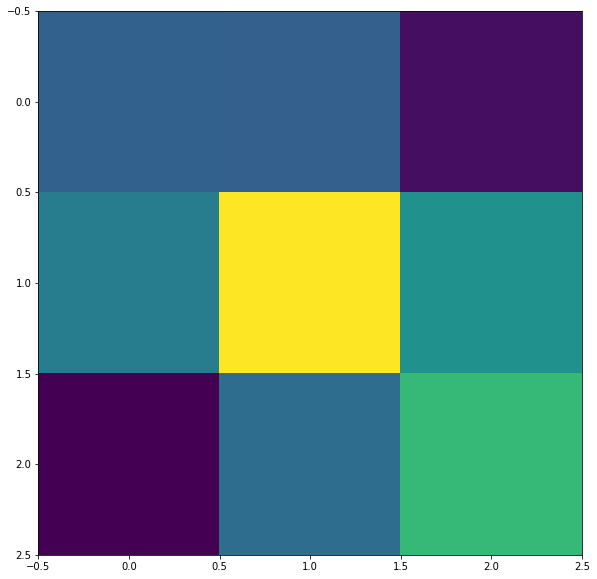

In [23]:
def test_model(algorithm, features, dev, test):
    
    dev2 = np.array(dev)
    test2 = np.array(test)
    
    # X for the training (90%)
    X_train = np.take(features, dev2-1,axis=0)
    # y for the training (90%)
    y_train = np.take(y_matrix, dev2-1, axis=0)
    
    # X for the test set (10%)
    X_test = np.take(features, test2-1, axis=0)
    # y for the test set (10%)
    y_test = np.take(y_matrix, test2-1, axis=0)
    
    evaluation_y = algorithm(X_train,y_train,X_test)
    TP0, TP1, TP2, FP0, FP1, FP2, FN0, FN1, FN2, TN0, TN1, TN2, recall, precision, f_measure, accuracy = calculations(evaluation_y,y_test)
    
    TP = TP0+TP1+TP2
    FP = FP0+FP1+FP2
    FN = FN0+FN1+FN2
    TN = TN0+TN1+TN2
    
    print("RECALL: ", recall)
    print("PRECISION: ", precision)
    print("F_MEASURE: ", f_measure)
    print("ACCURACY: ", accuracy)
    print("CONFUSION MATRIX:")
    confusionmatrix = np.asarray([[TP, FP], [FN, TN]])
    confusionmatrix2 = np.asarray([[(TP0+TN1+TN2),(FP0+FN1+TN2),(FP0+FN2+TN1)],
                                  [(FP1+FN0+TN2),(TN2+TP1+TN0),(FP1+FN2+TN0)],
                                  [(FP2+FN0+TN1),(FP2+FN1+TN0),(TP1+TN0+TN1)]])
    
    return(confusionmatrix, confusionmatrix2)
cm, cm2 = test_model(log_reg, bow_features_set, dev_set, test_set) 
plt.imshow(cm)
plt.imshow(cm2)
plt.show

---

Now, the model is tested on the tweets on which there was no substantial agreement. Most of these are counted as offensive language.

In [24]:
df_high_agreement = df[df[["hate_speech", "offensive_language", "neither"]].gt(0).sum(axis=1) == 1]

0      263
1    14302
2     2872
Name: class, dtype: int64

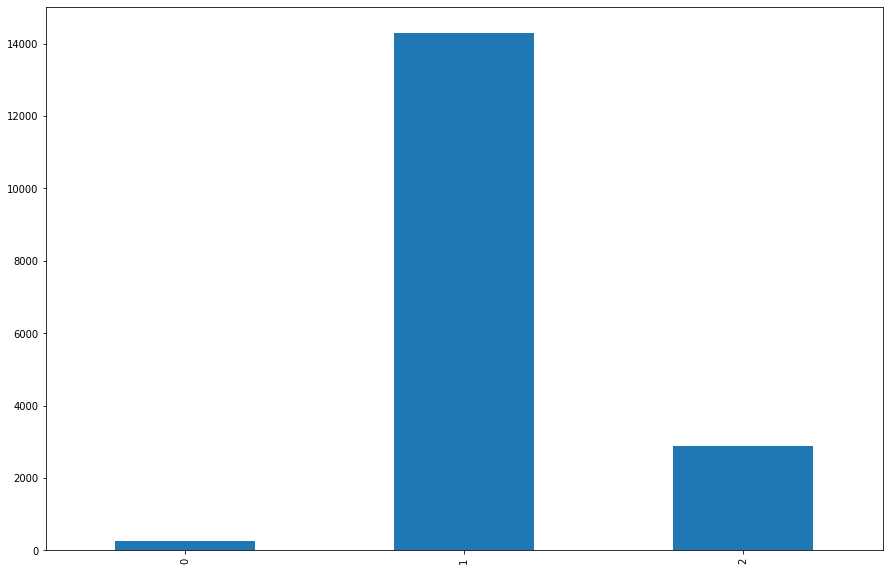

In [25]:
df_high_agreement['class'].value_counts(sort = False).plot.bar(color='#1f77b4')
df_high_agreement['class'].value_counts(sort = False)

17437
24729
[    3     5     9 ... 25290 25291 25292]
22256
train... logistic regression
RECALL:  0.3581902517487749
PRECISION:  0.47881205673758864
F_MEASURE:  0.333448306835534
ACCURACY:  0.8317152103559871
CONFUSION MATRIX:


<function matplotlib.pyplot.show(*args, **kw)>

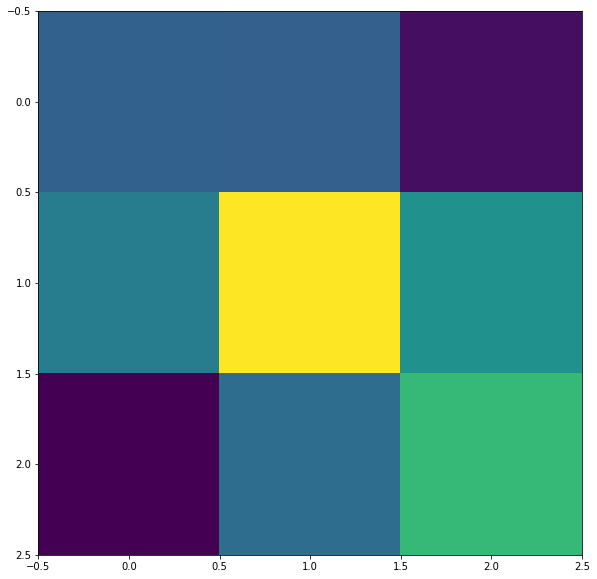

In [26]:
highset = np.array(df_high_agreement['class'].keys())
print(len(highset))

allset = np.array(list(df_dict['class'].keys())) 
print(len(allset))
#IDs of tweets on which there were no sub. agreement:
noagreement = np.setdiff1d(allset,highset)
print(noagreement)
devvy = np.array(dev_set)
print(len(devvy))


newtest = []
for x in test_set:
    if allset[x] not in highset:
        newtest.append(x)
        
newcm, newcm2 = test_model(log_reg, bow_features_set, dev_set, newtest)

#hatespeech based confusion matrix:
plt.imshow(cm)
#overall confusion matrix:
plt.imshow(cm2)
plt.show

---

### References

T. Davidson, D. Warmsley, M.W. Macy & I. Weber (2017). Automated Hate Speech Detection and the Problem of Offensive Language. In *Proceedings of the Eleventh International Conference on Web and Social Media, ICWSM 2017*: 512-515.

J.T. Nockleby (2000). Hate Speech. In L.W. Levy, K.L. Karst et al. (eds.), *Encyclopedia of the American Constitution*, New York: Macmillan, pp. 1277-1279.

A. Schmidt & M. Wiegand (2017). A Survey on Hate Speech Detection using Natural Language Processing. In *Proceedings of the Fifth International Workshop on Natural Language Processing for Social Media*: 1-10.

---